# Advanced AI Coursework - CNNs for classifying satellite images

## Outline
This notebook explores two CNNs to classify images taken from the EuroSat dataset. We will be using the RGB variant, as it is easier to visualise than the 13 band version.
The first CNN is a 'standard' CNN for classifying images, simply using convolution and pooling layers followed by dense layers. The second is a more advanced CNN based on the standard, utilising more creative layers in order with the goal of achieving better classifying results.

The EuroSat dataset is provided by reference [1], and its sub-references.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Plotting Functions

In [26]:
### Both plot_loss and plot_accuracy were directly influenced from [3]
def plot_loss(history_passed, epochs):
    # Plot a graph of training and validation loss against epochs
    plt.figure(figsize=(5, 5))
    loss = history_passed.history['loss']
    val_loss = history_passed.history['val_loss']

    epochs_range = range(epochs)

    plt.plot(epochs_range, loss, label='Training Data Loss')
    plt.plot(epochs_range, val_loss, label='Validation Data Loss')
    plt.legend(loc='lower left')
    plt.title('Loss over epochs')
    plt.show()
    
def plot_accuracy(history_passed, epochs):
    # Plot a graph of training and validation accuracy against epochs
    plt.figure(figsize=(5, 5))
    loss = history_passed.history['accuracy']
    val_loss = history_passed.history['val_accuracy']

    epochs_range = range(epochs)

    plt.plot(epochs_range, loss, label='Training Data Accuracy')
    plt.plot(epochs_range, val_loss, label='Validation Data Accuracy')
    plt.legend(loc='lower left')
    plt.title('Accuracy over epochs')
    plt.show()

### plot_images() was directly influenced from [2]
def plot_images(image_dataset, count):
    # Plot a selection of _count_ images from the dataset
    plt.figure(figsize=(10, 10))

    for images, labels in image_dataset.take(1):
        for i in range(3):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
        
    plt.show()

def plot_classification_vs_reality(model, dataset):
    # Plot a comparison of 6 images, with a tag indicating if the model classified them correctly
    plt.figure(figsize=(10, 10))
    first_batch = dataset.take(1)
    
    for image, label in first_batch:
        pass
    first_batch = first_batch.cache()
    
    predictions = model.predict(first_batch)
    predictions_filtered = []
    
    for element in predictions:
        predictions_filtered.append(max(range(len(element)), key=element.__getitem__))
    
    for images, labels in first_batch:
        for i in range(6):
            predict_id = predictions_filtered[i]
            real_id = labels[i]
            title = class_names[predict_id]
            if predict_id == real_id:
                title += " (Correct)"
            else:
                title += " (Incorrect)"
            
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))            
            plt.title(title)
            plt.axis("off")
            
    plt.show()

def plot_feature_maps(model, dataset):
    # Plot the activation of the first layer of feature maps in the model, once an image has been run through
    first_batch = dataset.take(1)
    
    for image, label in first_batch:
        pass
    first_batch = first_batch.cache()

    feature_maps = model.predict(first_batch)
    input_image = None
    input_label = None
    for images, labels in first_batch:
        input_image = images[0]
        input_label = labels[0]
        break
    
    plt.figure(figsize=(5, 5))
    ax = plt.plot(1, 1)
    plt.imshow(input_image.numpy().astype("uint8"))
    plt.title(class_names[input_label])
    plt.axis("off")    
    plt.show()
    
    
    plt.figure(figsize=(10, 10))
    ### This section is taken directly from [4]
    ix = 1
    for _ in range(4):
        for _ in range(8):
            ax = plt.subplot(4, 8, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    ### end reference to [4]        
    
    plt.show()

# Dataset
We will use the EuroSAT dataset, which is a collection of 27000 images taken from a satellite, with 10 total classes. 
We access this using keras preprocessing to convert the images in their separate directories into a `tensorflow dataset` class. This high level class can be used to avoid conversions, copies and inneficient use of memory that could stem from manually manipulating arrays.

In [3]:
batch_size = 32
total_images = 27000

### Dataset from [1], download and loading from [2]
dataset_url = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"
base_directory = "/home/datasets"

data_dir = tf.keras.utils.get_file(
    origin=dataset_url, fname="euroSAT", extract=True, cache_subdir=base_directory
)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_directory + "/2750", image_size=(64, 64), batch_size=batch_size
)

class_names = dataset.class_names

Found 27000 files belonging to 10 classes.


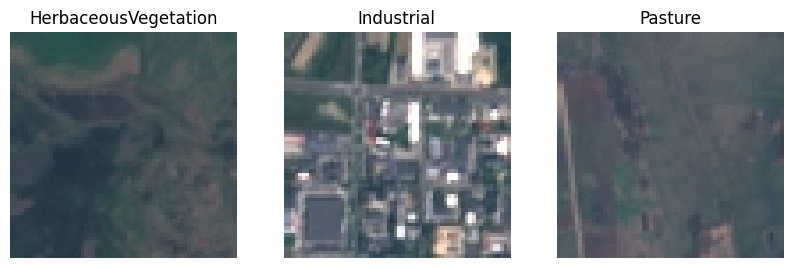

In [8]:
# The following are some random example images from the dataset to provide an overview.
plot_images(dataset, 3)

In [9]:
# Split the dataset into training and evaluation. 
# We use the take and skip functions to avoid costly memory manipulation.
total_batches = total_images // batch_size
train_count = int(total_batches*0.85)

train_dataset = dataset.take(train_count)
evaluation_dataset = dataset.skip(train_count)

# Model definition and training

## Standard model

In [10]:
s_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10)
])

s_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
s_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

In [11]:
s_number_of_epochs = 15

s_history = s_model.fit(
    train_dataset,
    validation_data=evaluation_dataset,
    epochs = s_number_of_epochs
)

Epoch 1/15
716/716 [==============================] - 8s 7ms/step - loss: 1.2275 - accuracy: 0.5345 - val_loss: 0.8998 - val_accuracy: 0.6659
Epoch 2/15
716/716 [==============================] - 4s 6ms/step - loss: 0.8207 - accuracy: 0.6957 - val_loss: 0.7694 - val_accuracy: 0.7121
Epoch 3/15
716/716 [==============================] - 4s 6ms/step - loss: 0.6879 - accuracy: 0.7470 - val_loss: 0.6223 - val_accuracy: 0.7754
Epoch 4/15
716/716 [==============================] - 4s 6ms/step - loss: 0.5916 - accuracy: 0.7859 - val_loss: 0.5863 - val_accuracy: 0.7769
Epoch 5/15
716/716 [==============================] - 4s 6ms/step - loss: 0.5369 - accuracy: 0.8057 - val_loss: 0.5052 - val_accuracy: 0.8207
Epoch 6/15
716/716 [==============================] - 4s 6ms/step - loss: 0.4695 - accuracy: 0.8318 - val_loss: 0.4952 - val_accuracy: 0.8239
Epoch 7/15
716/716 [==============================] - 4s 6ms/step - loss: 0.4164 - accuracy: 0.8509 - val_loss: 0.5204 - val_accuracy: 0.8222
Epoch 

## Advanced model

In [12]:
# Advanced model
adv_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    tf.keras.layers.RandomRotation(factor=0.5),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.GaussianNoise(0.05),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10)
])

adv_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
adv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [13]:
adv_number_of_epochs = 40

adv_history = adv_model.fit(
    train_dataset,
    validation_data=evaluation_dataset,
    epochs = adv_number_of_epochs
)

Epoch 1/40
716/716 [==============================] - 6s 7ms/step - loss: 1.3908 - accuracy: 0.4588 - val_loss: 1.0196 - val_accuracy: 0.6062
Epoch 2/40
716/716 [==============================] - 5s 7ms/step - loss: 0.9137 - accuracy: 0.6636 - val_loss: 0.9139 - val_accuracy: 0.6566
Epoch 3/40
716/716 [==============================] - 5s 7ms/step - loss: 0.7644 - accuracy: 0.7203 - val_loss: 0.6867 - val_accuracy: 0.7493
Epoch 4/40
716/716 [==============================] - 5s 7ms/step - loss: 0.6880 - accuracy: 0.7459 - val_loss: 0.6969 - val_accuracy: 0.7417
Epoch 5/40
716/716 [==============================] - 5s 7ms/step - loss: 0.6185 - accuracy: 0.7748 - val_loss: 0.6169 - val_accuracy: 0.7708
Epoch 6/40
716/716 [==============================] - 5s 7ms/step - loss: 0.5685 - accuracy: 0.7944 - val_loss: 0.6567 - val_accuracy: 0.7644
Epoch 7/40
716/716 [==============================] - 5s 7ms/step - loss: 0.5346 - accuracy: 0.8097 - val_loss: 0.5375 - val_accuracy: 0.8053
Epoch 

# Model performance analysis
The following graphs outline the loss and accuracy acheived by the models over the given number of epochs.

## Standard model

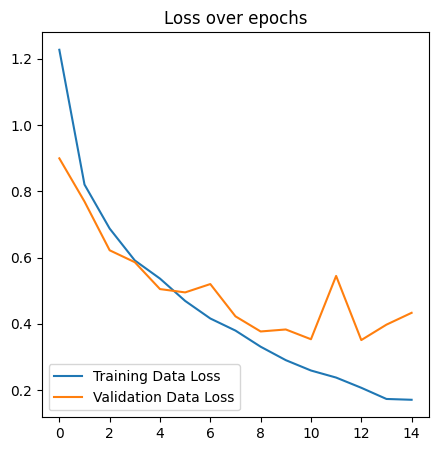

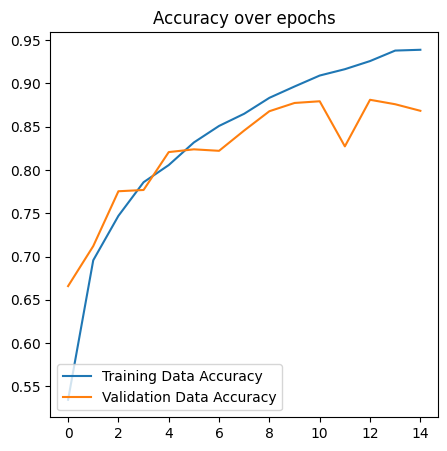

In [14]:
plot_loss(s_history, s_number_of_epochs)
plot_accuracy(s_history, s_number_of_epochs)

## Advanced model

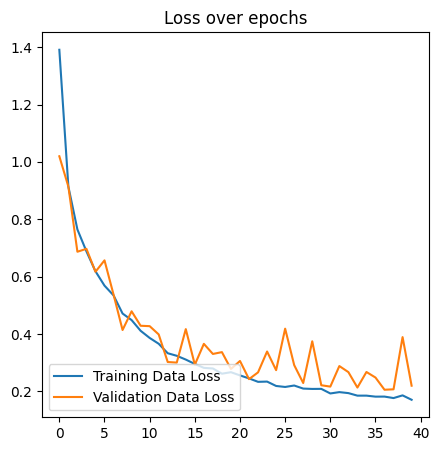

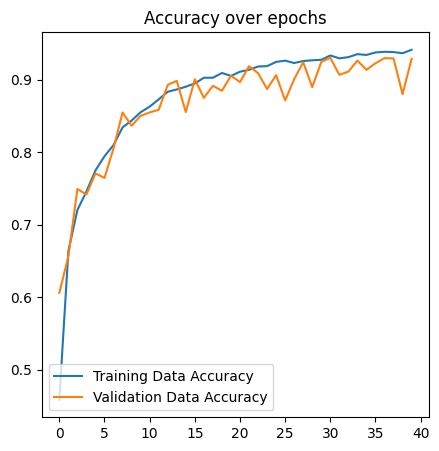

In [15]:
plot_loss(adv_history, adv_number_of_epochs)
plot_accuracy(adv_history, adv_number_of_epochs)

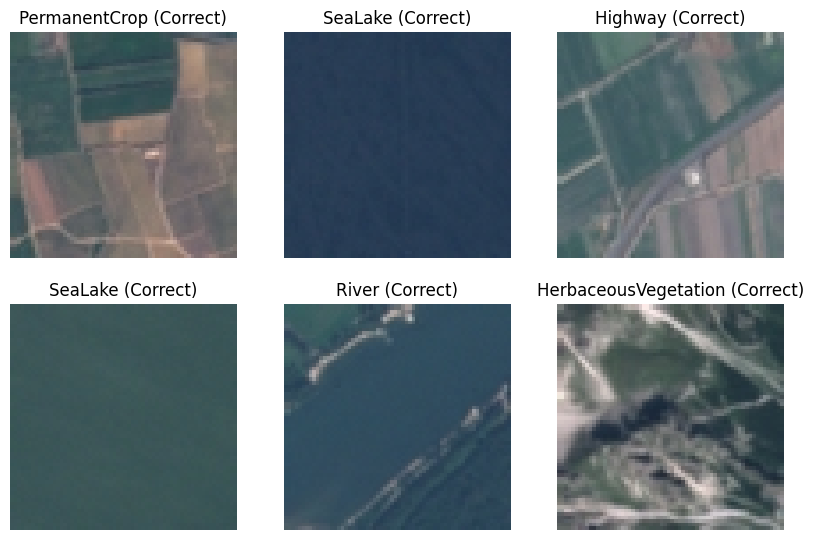

In [44]:
# We can now plot some random example images, and check if the model has correctly classified them.
# The title indicates what the model believes the image to show, and the '(In)Correct' marker shows 
# if the classification matches the actual label.
plot_classification_vs_reality(adv_model, evaluation_dataset)

# Feature map insight
We can also view the feature map activation for the first layer of the advanced model. To do this, we create a new model which only references the first layer, and compare the input to the output. Note that while the model below has other layers such as random rotation, these are only active for training, so do not impact the output.

In [17]:
### Feature model structure from [4]
feature_model = tf.keras.models.Model(inputs=adv_model.inputs, outputs=adv_model.layers[2].output)
feature_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1_input (InputLay  [(None, 64, 64, 3)]      0         
 er)                                                             
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


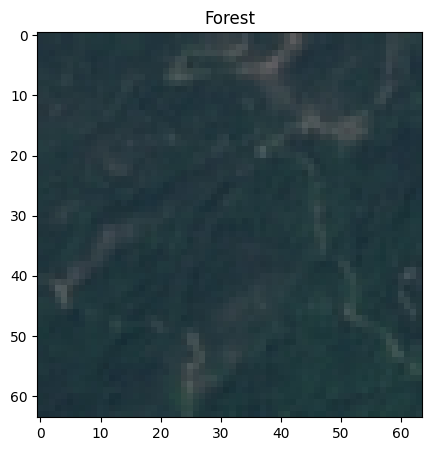

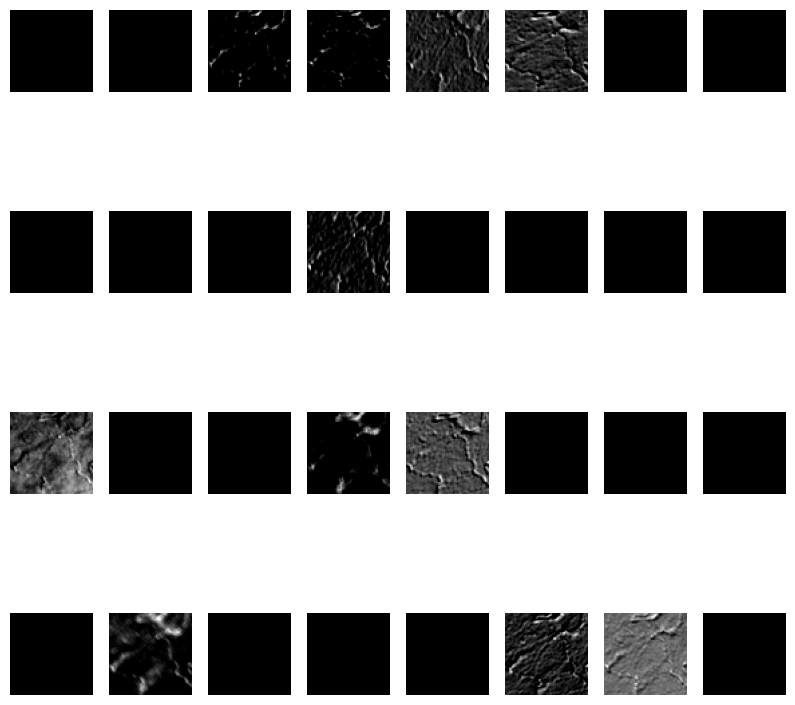

In [27]:
plot_feature_maps(feature_model, evaluation_dataset)

# Automatically optimising advanced model parameters
As a final stage for the experimental model, we can set the computer to automcatically determine which parameters are best for the model. As we do not have infinite computational power, the findings on the dataset so far are crucial for reducing the domain of possible values.

We will keep the number/format of layers static, and instead change the following values:
- Gaussian noise after the flattening layer
- The number of nodes on the penultimate layer
- The kernel sizes for the filters

Then, for each set of parameters:
 - We make the model
 - Train 
 - Get average of last 10 losses in the history
 - If better than any of the top 3 models so far, replace it
    
We then output the top 3 configurations, for a human to decide. This is because while we can use the losses to make some decisions, knowing that more nodes or a higher gaussian noise value will require more epochs to fully train is not programmed in.

In [23]:
def auto_determine():
    noise_values = [0.05, 0.1, 0.15]
    dense_layer_values = [50, 100, 150, 200]
    kernel_sizes = [3, 4]

    auto_epochs = 35

    best_losses = [10, 10, 10]
    best_configs = ["None", "None", "None"]

    for noise in noise_values:
        for dense_number in dense_layer_values:
            for kernel_size in kernel_sizes:
                print("Evaluating next model")
                try:
                    auto_model = tf.keras.Sequential([
                        tf.keras.layers.Rescaling(1./255, input_shape=(64, 64, 3)),
                        tf.keras.layers.RandomRotation(factor=0.5),
                        tf.keras.layers.Conv2D(32, kernel_size, activation='relu'),
                        tf.keras.layers.MaxPooling2D(),
                        tf.keras.layers.Conv2D(64, kernel_size, activation='relu'),
                        tf.keras.layers.MaxPooling2D(),
                        tf.keras.layers.Conv2D(128, kernel_size, activation='relu'),
                        tf.keras.layers.MaxPooling2D(),
                        tf.keras.layers.Conv2D(256, kernel_size, activation='relu'),
                        tf.keras.layers.MaxPooling2D(),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.GaussianNoise(noise),
                        tf.keras.layers.Dense(dense_number, activation='relu'),
                        tf.keras.layers.Dense(10)
                    ])

                    auto_model.compile(optimizer='adam',
                                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                  metrics=['accuracy'])

                    auto_history = auto_model.fit(
                        train_dataset,
                        validation_data=evaluation_dataset,
                        epochs = auto_epochs,
                        verbose=0
                    )

                    last_five = auto_history.history['val_loss'][-5:]
                    auto_average = sum(last_five)/len(last_five)

                    for x in range(len(best_losses)):
                        if auto_average < best_losses[x]:
                            best_losses[x] = auto_average
                            best_configs[x] = f'Noise={noise}, kernel_size={kernel_size}, dense_value={dense_number}'
                            break
                            
                except KeyboardInterrupt:
                    print(best_losses)
                    print(best_configs)
                    raise KeyboardInterrupt

    print(best_losses)
    print(best_configs)

The function is not run without being called, because it takes a long time to run through all the models. If desired, it can be called using `auto_determine()`.

# Conclusion
We will conclude with comparison between the 'standard' and 'advanced' models.

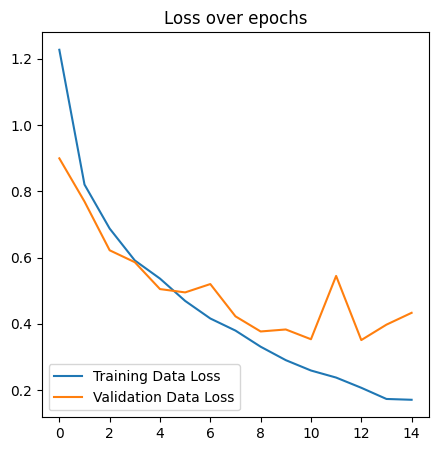

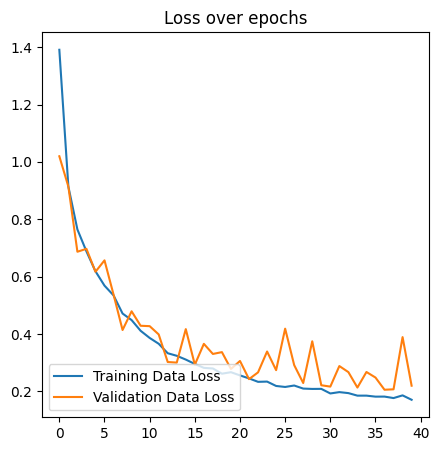

In [24]:
plot_loss(s_history, s_number_of_epochs)
plot_loss(adv_history, adv_number_of_epochs)

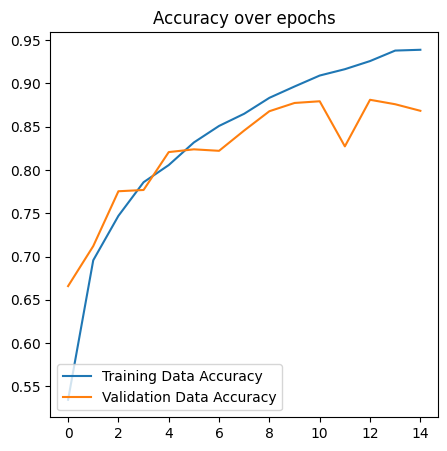

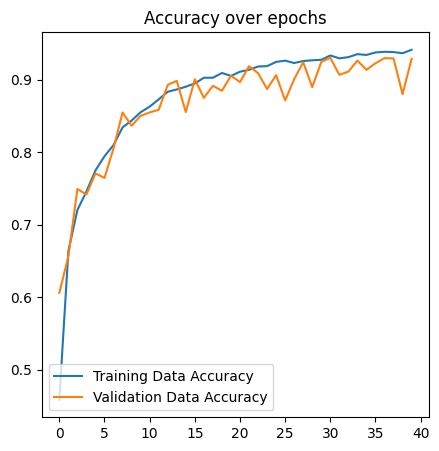

In [25]:
plot_accuracy(s_history, s_number_of_epochs)
plot_accuracy(adv_history, adv_number_of_epochs)

Overall, the 'advanced' model did provide more accuracy and less loss than the 'standard' model, however it did require 25 more epochs to train to that point. One interesting point is that the advanced model only takes the same number of epochs to get to the same level of classification as the standard, despite having almost double the number of trainable parameters.
Detailed comparison will take place in the accompanying documentation.

References:
- [1] https://github.com/phelber/eurosat
- [2] https://towardsdatascience.com/introduction-to-keras-part-one-data-loading-43b9c015e27c
- [3] https://www.tensorflow.org/tutorials/images/classification
- [4] https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/